In [1]:
import numpy as np
import os

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

color_dict = {
    0 : ["EPI", [73, 0, 106]],
    1 : ["GLD", [108, 0, 115]],
    2 : ["INF", [145, 1, 122]],
    3 : ["RET", [181, 9, 130]],
    4 : ["FOL", [216, 47, 148]],
    5 : ["PAP", [236, 85, 157]],
    6 : ["HYP", [254, 246, 242]],
    7 : ["KER", [248, 123, 168]],
    8 : ["BKG", [0, 0, 0]],
    9 : ["BCC", [127, 255, 255]],
    10 : ["SCC", [127, 255, 142]],
    11 : ["IEC", [255, 127, 127]]
}

colors = []
for i in range(12):
    c = [_/255. for _ in color_dict[i][1]]
    colors.append(c)
    
seg_cmap = ListedColormap(colors, name='segmentationCMAP', N=None)

In [3]:
#DATA_DIR = "/home/simon/Desktop/SegmentationRevision/PROB_MAPS_REDO"
#DATA_DIR = "/media/simon/UNTITLED/PROB_MAPS_REDO"
#DATA_DIR = "/media/simon/UNTITLED/PROB_MAPS_REDO/maps/"
DATA_DIR = "/home/simon/Desktop/SegmentationRevision/NEW_PROB_MAPS/"

In [4]:
test_names = ["IEC_45",
"SCC_23",
"SCC_32",
"BCC_131",
"BCC_135",
"SCC_52",
"SCC_20",
"BCC_4",
"SCC_9",
"BCC_48",
"BCC_80",
"SCC_38",
"BCC_95",
"BCC_86",
"BCC_133",
"IEC_75",
"BCC_51",
"IEC_41",
"BCC_90",
"BCC_74",
"BCC_22",
"SCC_7",
"SCC_24",
"IEC_22",
"IEC_23",
"BCC_60",
"BCC_61",
"IEC_34",
"IEC_35",
"BCC_23",
"BCC_24",
"IEC_75_HEAL_2",
"SCC_32_HEAL",
"BCC_95_HEAL_2",
"BCC_22_HEAL",
"BCC_131_HEAL_2",
"BCC_48_HEAL_1",
"IEC_45_HEAL",
"BCC_60_HEAL",
"BCC_48_HEAL_2",
"IEC_75_HEAL_1",
"BCC_74_HEAL",
"BCC_131_HEAL_1",
"BCC_86_HEAL_1",
"BCC_86_HEAL_2",
"BCC_90_HEAL",
"BCC_95_HEAL_1"
             ]

val_names = ["BCC_110",
"BCC_65",
"BCC_3",
"BCC_112",
"BCC_126",
"IEC_85",
"BCC_39",
"SCC_3",
"BCC_9",
"SCC_37",
"BCC_99",
"BCC_53",
"BCC_70",
"BCC_117",
"BCC_15",
"BCC_104",
"IEC_78",
"BCC_109",
"BCC_93",
"BCC_138",
"BCC_100",
"BCC_91",
"IEC_2",
"IEC_3",
"SCC_1",
"SCC_2",
"BCC_5",
"BCC_6",
"BCC_9_HEAL_1",
"BCC_9_HEAL_2",
"BCC_15_HEAL",
"BCC_15_HEAL_2",
"BCC_39_HEAL_1",
"BCC_39_HEAL_2",
"BCC_53_HEAL",
"BCC_64_HEAL",
"BCC_91_HEAL",
"BCC_93_HEAL",
"BCC_99_HEAL",
"BCC_109_HEAL",
"BCC_126_HEAL_1",
"BCC_126_HEAL_2"
]

test_names = [f + ".npy" for f in test_names]
val_names = [f + ".npy" for f in val_names]

In [5]:
all_files = [ file for file in os.listdir(DATA_DIR)]

In [6]:
train_files = []
test_files = []
val_files = []

for file in all_files:
    if file in test_names:
        test_files.append(file)
    elif file in val_names:
        val_files.append(file)
    else:
        train_files.append(file)

In [7]:
len(train_files)

291

In [8]:
len(test_files)

47

In [9]:
len(val_files)

42

# Data Gen

In [10]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

class DataGen:
    """
    A data generator that can handing multiple workers if used in conjunction with
    the model.fit_generator method.
    Enables simplification of images by using pixelation e.g. 128x128 >> 16x16 >> 128x128,
    paired with smooth transitions between scales using alpha, as well as gaussian blurring
    controlled by sigma.
    It is a generator so `X, y = next(generator)` will get a new batch, but indexing also works and
    is preferred e.g. `X, y = generator[0]`.
    """

    def __init__(self, img_dir, batch_size, shuffle=True, apply_to_all=False):
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.files = np.array(os.listdir(self.img_dir))
        self.n = len(self.files)
        self.indices = np.arange(0, self.n)
        if shuffle:
            np.random.shuffle(self.indices)
        self.pos = 0
        self.apply_to_all = apply_to_all

    def _get_indices(self, i):
        return self.indices[i * self.batch_size:i * self.batch_size + self.batch_size]

    def __getitem__(self, i):
        batch = []
        labels = []
        files = self.files[self._get_indices(i)]
        for file in files:
            # Get input
            #img = one_hot(np.expand_dims(np.argmax(np.load(os.path.join(self.img_dir, file)), axis=-1), 0))
            img = np.expand_dims(np.load(os.path.join(self.img_dir, file)), 0)
            
            # Get label
            if "HEAL" in file:
                labels.append(np.array([1, 0, 0, 0.]))
            elif "BCC" in file:
                labels.append(np.array([0., 1, 0, 0]))
            elif "IEC" in file:
                labels.append(np.array([0, 0., 1, 0]))
            elif "SCC" in file:
                labels.append(np.array([0, 0, 0., 1]))
                
            if self.apply_to_all:
                img = softmax(img)
            # Add to batch
            batch.append(img)
                    
        return batch[0], np.stack(labels)

    def __next__(self):
        self.pos += 1
        if self.pos > self.n // self.batch_size:
            self.pos = 1
        return self.__getitem__(self.pos - 1)
    
    def set_files(self, files):
        self.files = np.array([os.path.join(self.img_dir, file) for file in files])
        self.n = len(self.files)
        self.indices = np.arange(0, self.n)
        np.random.shuffle(self.indices)
        self.pos = 0
        print("files updated")

In [11]:
train_gen = DataGen(DATA_DIR, 1, apply_to_all=True)
val_gen = DataGen(DATA_DIR, 1, apply_to_all=True)
test_gen = DataGen(DATA_DIR, 1, apply_to_all=True)

In [12]:
train_gen.set_files(train_files)
val_gen.set_files(val_files)
test_gen.set_files(test_files)

files updated
files updated
files updated


# Model

In [13]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam

Using TensorFlow backend.
/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/simon/anaconda3/envs/DL/lib/p

In [14]:
import keras.backend as K

In [15]:
K.clear_session()

model_in = Input(shape=(None, None, 12))
x = Conv2D(32, (3, 3), padding="same", activation="relu")(model_in)
x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation="relu")(x)
model_out = Dense(4, activation="softmax")(x)
model = Model(inputs=[model_in], outputs=[model_out])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 12)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    3488      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total para

In [16]:
model.compile(optimizer=(Adam(lr=0.001)), loss='categorical_crossentropy', metrics=["acc"])

In [17]:
# history = model.fit_generator(generator=train_gen,
#                               steps_per_epoch=train_gen.n,
#                               epochs=1,
#                               validation_data=val_gen,
#                               validation_steps=val_gen.n,
#                               workers=6,
#                               use_multiprocessing=True,
#                               #callbacks=[check_point]
#                              )

In [50]:
#model.save_weights("./classification_weights__EPOCH_7_train_95_val_1.h5")

In [17]:
model.load_weights("./classification_weights__EPOCH_5_train_95_val_1.h5")

<br>

In [41]:
loss, acc = model.evaluate_generator(generator=test_gen, steps=test_gen.n, verbose=1)
acc # epoch 4

0.8936170212765957

In [53]:
loss, acc = model.evaluate_generator(generator=test_gen, steps=test_gen.n, verbose=1)
acc #  EPOCH 5

47/47 [==============================] - 16s 339ms/step


0.9361702127659575

In [54]:
true = []
pred = []
for i in range(test_gen.n):
    X, y = test_gen[i]
    
    
    y_pred = model.predict(X)
    
    pred.append(y_pred)
    true.append(y)
    
true = np.vstack(true)
pred = np.vstack(pred)

In [55]:
pred.shape

(47, 4)

In [56]:
np.argmax(pred, axis=-1) == np.argmax(true, axis=-1).flatten()

array([ True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [57]:
cm = np.zeros((4, 4))

In [58]:
y_pred = np.argmax(pred, axis=-1)
y_true = np.argmax(true, axis=-1).flatten()

np.sum(y_pred == y_true) / len(y_true)

0.9361702127659575

In [59]:
for i in range(len(y_pred)):
    r = y_true[i]
    c = y_pred[i]
    cm[r, c] += 1
cm

array([[16.,  0.,  0.,  0.],
       [ 1., 14.,  1.,  0.],
       [ 0.,  1.,  6.,  0.],
       [ 0.,  0.,  0.,  8.]])

# Check distributions

In [23]:
# TRAIN
distros = []
n = len(train_gen.files)
for i, file in enumerate(train_gen.files):
    print(i, "of", n)
    img = np.load(file)
    dist = np.mean(img, axis=(0, 1))
    distros.append(dist)
distros = np.stack(distros)

0 of 291
1 of 291
2 of 291
3 of 291
4 of 291
5 of 291
6 of 291
7 of 291
8 of 291
9 of 291
10 of 291
11 of 291
12 of 291
13 of 291
14 of 291
15 of 291
16 of 291
17 of 291
18 of 291
19 of 291
20 of 291
21 of 291
22 of 291
23 of 291
24 of 291
25 of 291
26 of 291
27 of 291
28 of 291
29 of 291
30 of 291
31 of 291
32 of 291
33 of 291
34 of 291
35 of 291
36 of 291
37 of 291
38 of 291
39 of 291
40 of 291
41 of 291
42 of 291
43 of 291
44 of 291
45 of 291
46 of 291
47 of 291
48 of 291
49 of 291
50 of 291
51 of 291
52 of 291
53 of 291
54 of 291
55 of 291
56 of 291
57 of 291
58 of 291
59 of 291
60 of 291
61 of 291
62 of 291
63 of 291
64 of 291
65 of 291
66 of 291
67 of 291
68 of 291
69 of 291
70 of 291
71 of 291
72 of 291
73 of 291
74 of 291
75 of 291
76 of 291
77 of 291
78 of 291
79 of 291
80 of 291
81 of 291
82 of 291
83 of 291
84 of 291
85 of 291
86 of 291
87 of 291
88 of 291
89 of 291
90 of 291
91 of 291
92 of 291
93 of 291
94 of 291
95 of 291
96 of 291
97 of 291
98 of 291
99 of 291
100 of 291

In [28]:
# Validation
val_distros = []
n = len(val_gen.files)
for i, file in enumerate(val_gen.files):
    print(i, "of", n)
    img = np.load(file)
    dist = np.mean(img, axis=(0, 1))
    val_distros.append(dist)
val_distros = np.stack(val_distros)

0 of 42
1 of 42
2 of 42
3 of 42
4 of 42
5 of 42
6 of 42
7 of 42
8 of 42
9 of 42
10 of 42
11 of 42
12 of 42
13 of 42
14 of 42
15 of 42
16 of 42
17 of 42
18 of 42
19 of 42
20 of 42
21 of 42
22 of 42
23 of 42
24 of 42
25 of 42
26 of 42
27 of 42
28 of 42
29 of 42
30 of 42
31 of 42
32 of 42
33 of 42
34 of 42
35 of 42
36 of 42
37 of 42
38 of 42
39 of 42
40 of 42
41 of 42


In [29]:
# Test
test_distros = []
n = len(test_gen.files)
for i, file in enumerate(test_gen.files):
    print(i, "of", n)
    img = np.load(file)
    dist = np.mean(img, axis=(0, 1))
    test_distros.append(dist)
test_distros = np.stack(test_distros)

0 of 47
1 of 47
2 of 47
3 of 47
4 of 47
5 of 47
6 of 47
7 of 47
8 of 47
9 of 47
10 of 47
11 of 47
12 of 47
13 of 47
14 of 47
15 of 47
16 of 47
17 of 47
18 of 47
19 of 47
20 of 47
21 of 47
22 of 47
23 of 47
24 of 47
25 of 47
26 of 47
27 of 47
28 of 47
29 of 47
30 of 47
31 of 47
32 of 47
33 of 47
34 of 47
35 of 47
36 of 47
37 of 47
38 of 47
39 of 47
40 of 47
41 of 47
42 of 47
43 of 47
44 of 47
45 of 47
46 of 47


In [61]:
# ------------ EXTERNAL --------------------------------------- #
EXT_DATA_DIR = "/media/simon/UNTITLED/PROB_MAPS_REDO/maps/"
ext_gen = DataGen(EXT_DATA_DIR, 1, apply_to_all=True)

In [31]:

ext_gen.files = [os.path.join(EXT_DATA_DIR, file) for file in ext_gen.files]

# Test
ext_distros = []
n = len(ext_gen.files)
for i, file in enumerate(ext_gen.files):
    print(i, "of", n)
    img = np.load(file)
    dist = np.mean(img, axis=(0, 1))
    ext_distros.append(dist)
ext_distros = np.stack(ext_distros)

0 of 116
1 of 116
2 of 116
3 of 116
4 of 116
5 of 116
6 of 116
7 of 116
8 of 116
9 of 116
10 of 116
11 of 116
12 of 116
13 of 116
14 of 116
15 of 116
16 of 116
17 of 116
18 of 116
19 of 116
20 of 116
21 of 116
22 of 116
23 of 116
24 of 116
25 of 116
26 of 116
27 of 116
28 of 116
29 of 116
30 of 116
31 of 116
32 of 116
33 of 116
34 of 116
35 of 116
36 of 116
37 of 116
38 of 116
39 of 116
40 of 116
41 of 116
42 of 116
43 of 116
44 of 116
45 of 116
46 of 116
47 of 116
48 of 116
49 of 116
50 of 116
51 of 116
52 of 116
53 of 116
54 of 116
55 of 116
56 of 116
57 of 116
58 of 116
59 of 116
60 of 116
61 of 116
62 of 116
63 of 116
64 of 116
65 of 116
66 of 116
67 of 116
68 of 116
69 of 116
70 of 116
71 of 116
72 of 116
73 of 116
74 of 116
75 of 116
76 of 116
77 of 116
78 of 116
79 of 116
80 of 116
81 of 116
82 of 116
83 of 116
84 of 116
85 of 116
86 of 116
87 of 116
88 of 116
89 of 116
90 of 116
91 of 116
92 of 116
93 of 116
94 of 116
95 of 116
96 of 116
97 of 116
98 of 116
99 of 116
100 of 116

### SHOW THEM

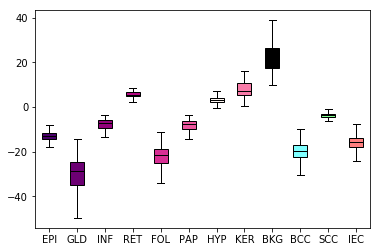

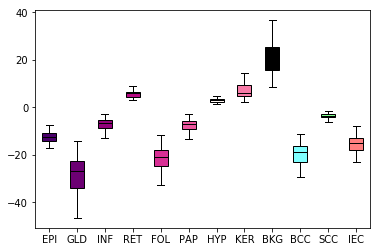

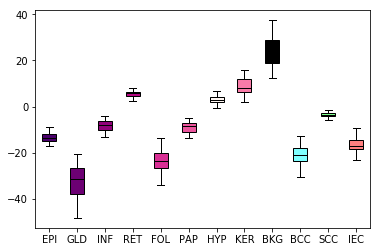

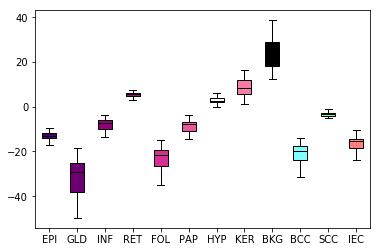

In [32]:
for distro in [distros, val_distros, test_distros, ext_distros]:
    plt.title("")
    bplot = plt.boxplot(distro,
                    showfliers=False,
                    medianprops=dict(color="black"),
                    patch_artist=True
                   )

    for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

    plt.xticks(ticks=range(1, 13), labels=[color_dict[_][0] for _ in range(12)])
    plt.show()

# Other data

In [62]:
loss, acc = model.evaluate_generator(generator=ext_gen, steps=ext_gen.n, verbose=1)
acc

116/116 [==============================] - 143s 1s/step


0.8793103448275862

In [63]:
true = []
pred = []
for i in range(ext_gen.n):
    
    print(i, "of", ext_gen.n)
    X, y = ext_gen[i]
    
    
    y_pred = model.predict(X)
    
    pred.append(y_pred)
    true.append(y)
    
true = np.vstack(true)
pred = np.vstack(pred)

0 of 116
1 of 116
2 of 116
3 of 116
4 of 116
5 of 116
6 of 116
7 of 116
8 of 116
9 of 116
10 of 116
11 of 116
12 of 116
13 of 116
14 of 116
15 of 116
16 of 116
17 of 116
18 of 116
19 of 116
20 of 116
21 of 116
22 of 116
23 of 116
24 of 116
25 of 116
26 of 116
27 of 116
28 of 116
29 of 116
30 of 116
31 of 116
32 of 116
33 of 116
34 of 116
35 of 116
36 of 116
37 of 116
38 of 116
39 of 116
40 of 116
41 of 116
42 of 116
43 of 116
44 of 116
45 of 116
46 of 116
47 of 116
48 of 116
49 of 116
50 of 116
51 of 116
52 of 116
53 of 116
54 of 116
55 of 116
56 of 116
57 of 116
58 of 116
59 of 116
60 of 116
61 of 116
62 of 116
63 of 116
64 of 116
65 of 116
66 of 116
67 of 116
68 of 116
69 of 116
70 of 116
71 of 116
72 of 116
73 of 116
74 of 116
75 of 116
76 of 116
77 of 116
78 of 116
79 of 116
80 of 116
81 of 116
82 of 116
83 of 116
84 of 116
85 of 116
86 of 116
87 of 116
88 of 116
89 of 116
90 of 116
91 of 116
92 of 116
93 of 116
94 of 116
95 of 116
96 of 116
97 of 116
98 of 116
99 of 116
100 of 116

In [64]:
cm = np.zeros((4, 4))

In [65]:
y_pred = np.argmax(pred, axis=-1)
y_true = np.argmax(true, axis=-1).flatten()

np.sum(y_pred == y_true) / len(y_true)

0.8793103448275862

In [66]:
for i in range(len(y_pred)):
    r = y_true[i]
    c = y_pred[i]
    cm[r, c] += 1
cm

array([[40.,  0.,  0.,  0.],
       [ 2., 22.,  3.,  0.],
       [ 1.,  1., 21.,  1.],
       [ 0.,  0.,  6., 19.]])

# Random Forrest

In [67]:
X_train_f = []
y_train_f = []

for j in range(train_gen.n):
    
    print(j, "of",train_gen.n )
    X, y = train_gen[j]
    
    groups, counts = np.unique(np.argmax(X, axis=-1), return_counts=True)
    total = np.sum(counts)
    vector = np.zeros(12)
    for i,g in enumerate(groups):
        vector[g] = counts[i] / total
        
        
    X_train_f.append(vector)
    y_train_f.append(np.argmax(y, axis=-1))
    
X_train_f = np.vstack(X_train_f)

0 of 291
1 of 291
2 of 291
3 of 291
4 of 291
5 of 291
6 of 291
7 of 291
8 of 291
9 of 291
10 of 291
11 of 291
12 of 291
13 of 291
14 of 291
15 of 291
16 of 291
17 of 291
18 of 291
19 of 291
20 of 291
21 of 291
22 of 291
23 of 291
24 of 291
25 of 291
26 of 291
27 of 291
28 of 291
29 of 291
30 of 291
31 of 291
32 of 291
33 of 291
34 of 291
35 of 291
36 of 291
37 of 291
38 of 291
39 of 291
40 of 291
41 of 291
42 of 291
43 of 291
44 of 291
45 of 291
46 of 291
47 of 291
48 of 291
49 of 291
50 of 291
51 of 291
52 of 291
53 of 291
54 of 291
55 of 291
56 of 291
57 of 291
58 of 291
59 of 291
60 of 291
61 of 291
62 of 291
63 of 291
64 of 291
65 of 291
66 of 291
67 of 291
68 of 291
69 of 291
70 of 291
71 of 291
72 of 291
73 of 291
74 of 291
75 of 291
76 of 291
77 of 291
78 of 291
79 of 291
80 of 291
81 of 291
82 of 291
83 of 291
84 of 291
85 of 291
86 of 291
87 of 291
88 of 291
89 of 291
90 of 291
91 of 291
92 of 291
93 of 291
94 of 291
95 of 291
96 of 291
97 of 291
98 of 291
99 of 291
100 of 291

In [68]:
X_val_f = []
y_val_f = []

for j in range(val_gen.n):
    
    print(j, "of",val_gen.n )
    X, y = val_gen[j]
    
    groups, counts = np.unique(np.argmax(X, axis=-1), return_counts=True)
    total = np.sum(counts)
    vector = np.zeros(12)
    for i,g in enumerate(groups):
        vector[g] = counts[i] / total
        
        
    X_val_f.append(vector)
    y_val_f.append(np.argmax(y, axis=-1))
    
X_val_f = np.vstack(X_val_f)

0 of 42
1 of 42
2 of 42
3 of 42
4 of 42
5 of 42
6 of 42
7 of 42
8 of 42
9 of 42
10 of 42
11 of 42
12 of 42
13 of 42
14 of 42
15 of 42
16 of 42
17 of 42
18 of 42
19 of 42
20 of 42
21 of 42
22 of 42
23 of 42
24 of 42
25 of 42
26 of 42
27 of 42
28 of 42
29 of 42
30 of 42
31 of 42
32 of 42
33 of 42
34 of 42
35 of 42
36 of 42
37 of 42
38 of 42
39 of 42
40 of 42
41 of 42


In [69]:
X_test_f = []
y_test_f = []

for j in range(test_gen.n):
    
    print(j, "of",test_gen.n )
    X, y = test_gen[j]
    
    groups, counts = np.unique(np.argmax(X, axis=-1), return_counts=True)
    total = np.sum(counts)
    vector = np.zeros(12)
    for i,g in enumerate(groups):
        vector[g] = counts[i] / total
        
        
    X_test_f.append(vector)
    y_test_f.append(np.argmax(y, axis=-1))
    
X_test_f = np.vstack(X_test_f)

0 of 47
1 of 47
2 of 47
3 of 47
4 of 47
5 of 47
6 of 47
7 of 47
8 of 47
9 of 47
10 of 47
11 of 47
12 of 47
13 of 47
14 of 47
15 of 47
16 of 47
17 of 47
18 of 47
19 of 47
20 of 47
21 of 47
22 of 47
23 of 47
24 of 47
25 of 47
26 of 47
27 of 47
28 of 47
29 of 47
30 of 47
31 of 47
32 of 47
33 of 47
34 of 47
35 of 47
36 of 47
37 of 47
38 of 47
39 of 47
40 of 47
41 of 47
42 of 47
43 of 47
44 of 47
45 of 47
46 of 47


<br>

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=100)

In [72]:
clf.fit(X_train_f, y_train_f)

/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [73]:
clf.score(X_train_f, y_train_f)

0.9621993127147767

In [75]:
clf.score(X_val_f, y_val_f)

0.8571428571428571

In [76]:
clf.score(X_test_f, y_test_f)

0.8723404255319149

In [77]:
y_pred = clf.predict(X_test_f)

In [78]:
y_true = np.array(y_test_f).flatten()

In [79]:
cm = np.zeros((4, 4))

for i in range(len(y_pred)):
    r = y_true[i]
    c = y_pred[i]
    cm[r, c] += 1

print(cm)

[[13.  2.  1.  0.]
 [ 1. 14.  1.  0.]
 [ 0.  1.  6.  0.]
 [ 0.  0.  0.  8.]]


In [80]:
features = clf.feature_importances_

# Plot Feature Importance

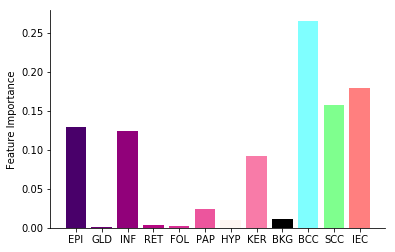

In [81]:
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Points
plt.bar(np.arange(12), features, color=colors, zorder=10)

plt.xticks(ticks=range(0, 12), labels=[color_dict[_][0] for _ in range(12)])
#plt.title("Two Classes")
plt.ylabel("Feature Importance")
plt.savefig("./feature_importance-random_forrest.png", dpi=300)
plt.show()

# Average Training

In [82]:
X_train_f.shape

(291, 12)

In [83]:
def encoder(pos):
    result = np.zeros(4)
    result[pos] = 1.
    return result

In [84]:
y_train = np.stack([encoder(pos[0]) for pos in y_train_f])

In [85]:
y_val = np.stack([encoder(pos[0]) for pos in y_val_f])

### Model

In [86]:
K.clear_session()

model_in = Input(shape=(12,))
x = Dense(64, activation="relu")(model_in)
model_out = Dense(4, activation="softmax")(x)
avg_model = Model(inputs=[model_in], outputs=[model_out])
avg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                832       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 1,092
Trainable params: 1,092
Non-trainable params: 0
_________________________________________________________________


In [87]:
avg_model.compile(optimizer=(Adam(lr=0.001)), loss='categorical_crossentropy', metrics=["acc"])

In [89]:
history = avg_model.fit(x=X_train_f, y=y_train, batch_size=1, epochs=10,
                    validation_data=[X_val_f, y_val])

Train on 291 samples, validate on 42 samples
Epoch 1/10
291/291 [==============================] - 1s 5ms/step - loss: 0.5691 - acc: 0.8282 - val_loss: 0.5688 - val_acc: 0.6905
Epoch 2/10
291/291 [==============================] - 1s 5ms/step - loss: 0.5271 - acc: 0.8488 - val_loss: 0.5085 - val_acc: 0.9286
Epoch 3/10
291/291 [==============================] - 1s 5ms/step - loss: 0.4907 - acc: 0.8625 - val_loss: 0.5107 - val_acc: 0.8810
Epoch 4/10
291/291 [==============================] - 1s 5ms/step - loss: 0.4644 - acc: 0.8900 - val_loss: 0.4838 - val_acc: 0.8095
Epoch 5/10
291/291 [==============================] - 1s 5ms/step - loss: 0.4379 - acc: 0.8935 - val_loss: 0.4410 - val_acc: 0.9286
Epoch 6/10
291/291 [==============================] - 1s 5ms/step - loss: 0.4125 - acc: 0.9003 - val_loss: 0.3957 - val_acc: 0.9286
Epoch 7/10
291/291 [==============================] - 1s 5ms/step - loss: 0.3867 - acc: 0.9107 - val_loss: 0.3710 - val_acc: 0.9286
Epoch 8/10
291/291 [===========

In [90]:
y_test = np.stack([encoder(pos[0]) for pos in y_test_f])

In [92]:
pred = avg_model.predict(X_test_f)

In [93]:
result = np.argmax(pred, axis=-1) == np.argmax(y_test, axis=-1)

In [94]:
np.sum(result) / len(result)

0.851063829787234

In [95]:
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(pred, axis=-1)

In [96]:
cm = np.zeros((4, 4))

for i in range(len(y_pred)):
    r = y_true[i]
    c = y_pred[i]
    cm[r, c] += 1

print(cm)

[[13.  3.  0.  0.]
 [ 2. 13.  1.  0.]
 [ 0.  1.  6.  0.]
 [ 0.  0.  0.  8.]]


# Nearest NeighBors

In [97]:
from sklearn.neighbors import KNeighborsClassifier

In [98]:
X_train_f.shape

(291, 12)

In [99]:
neigh = KNeighborsClassifier(n_neighbors=4)

In [100]:
neigh.fit(X_train_f, y_train_f)

/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [101]:
neigh.score(X_train_f, y_train_f)

0.8487972508591065

In [102]:
neigh.score(X_val_f, y_val_f)

0.8333333333333334

In [103]:
neigh.score(X_test_f, y_test_f)

0.8085106382978723

In [104]:
y_pred = neigh.predict(X_test_f)

In [105]:
y_true = np.array([ thing[0] for thing in y_test_f])

In [106]:
cm = np.zeros((4, 4))

for i in range(len(y_pred)):
    r = y_true[i]
    c = y_pred[i]
    cm[r, c] += 1

print(cm)

[[11.  1.  4.  0.]
 [ 0. 14.  2.  0.]
 [ 2.  0.  5.  0.]
 [ 0.  0.  0.  8.]]


# Gradients

In [90]:
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)

In [91]:
reset_weights(model)

In [32]:
all_files = train_gen.files

In [34]:
healthy = [ file for file in all_files if "HEAL" in file]
bcc = [ file for file in all_files if "BCC" in file]
iec = [ file for file in all_files if "IEC" in file]
scc = [ file for file in all_files if "SCC" in file]

In [19]:
def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [35]:
gen = DataGen(".", 1, apply_to_all=True)

files updated


In [43]:
X, y = gen[3]

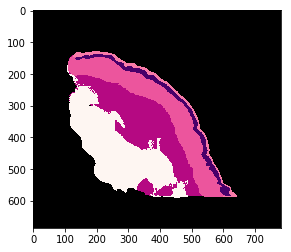

In [67]:
plt.imshow(np.argmax(X, axis=-1)[0], vmin=0, vmax=11, cmap=seg_cmap)
plt.show()

In [95]:
gen.set_files(healthy)
pos = 0

loss = -model.layers[-1].output[:, pos]
input_tensor = model.inputs[0]
grads = K.gradients(loss, input_tensor)[0]
grads = normalize(grads)
# this function returns the loss and grads given the input picture
get_grads = K.function([input_tensor], [grads])


healthy_features = []
for i in range(gen.n):
    
    print(i+1, "of", gen.n)
    
    X, y = gen[i]
    
    g = get_grads([X])[0][0]
    
    features = np.mean(np.abs(g), axis=(0, 1))
    
    features /= features.max()
    
    healthy_features.append(features)

#     fig, ax = plt.subplots(1, 2, figsize=(12, 12))
#     ax[0].imshow(np.argmax(X, axis=-1)[0], vmin=0, vmax=11, cmap=seg_cmap)
#     #plt.show()
    
#     img = np.mean(np.abs(g), axis=-1)
#     img /= img.max()
    
#     ax[1].imshow(img, cmap="magma")
#     plt.show()

healthy_features = np.stack(healthy_features)

files updated
1 of 60
2 of 60
3 of 60
4 of 60
5 of 60
6 of 60
7 of 60
8 of 60
9 of 60
10 of 60
11 of 60
12 of 60
13 of 60
14 of 60
15 of 60
16 of 60
17 of 60
18 of 60
19 of 60
20 of 60
21 of 60
22 of 60
23 of 60
24 of 60
25 of 60
26 of 60
27 of 60
28 of 60
29 of 60
30 of 60
31 of 60
32 of 60
33 of 60
34 of 60
35 of 60
36 of 60
37 of 60
38 of 60
39 of 60
40 of 60
41 of 60
42 of 60
43 of 60
44 of 60
45 of 60
46 of 60
47 of 60
48 of 60
49 of 60
50 of 60
51 of 60
52 of 60
53 of 60
54 of 60
55 of 60
56 of 60
57 of 60
58 of 60
59 of 60
60 of 60


In [106]:
test_gen.files[0].split("/")[-1].split(".")[0] + ".png"

'BCC_48_HEAL_2.png'

In [109]:
gen.set_files(test_gen.files)


for i in range(gen.n):
    
    print(i+1, "of", gen.n)
    
    X, y = gen[i]
    
    
    pos = np.argmax(y)
    
    # Get Grads
    loss = -model.layers[-1].output[:, pos]
    input_tensor = model.inputs[0]
    grads = K.gradients(loss, input_tensor)[0]
    grads = normalize(grads)
    # this function returns the loss and grads given the input picture
    get_grads = K.function([input_tensor], [grads])
    g = get_grads([X])[0][0]


    fig, ax = plt.subplots(1, 2, figsize=(12, 12))
    ax[0].imshow(np.argmax(X, axis=-1)[0], vmin=0, vmax=11, cmap=seg_cmap)
    ax[0].axis("off")
    #plt.show()
    
    img = np.mean(np.abs(g), axis=-1)
    img /= img.max()
    
    ax[1].imshow(img, cmap="magma")
    ax[1].axis("off")
    
    
    plt.savefig(f"./FEATURE_IMPORTANCE/{i}.png", dpi=100)
    plt.close()

files updated
1 of 47
2 of 47
3 of 47
4 of 47
5 of 47
6 of 47
7 of 47
8 of 47
9 of 47
10 of 47
11 of 47
12 of 47
13 of 47
14 of 47
15 of 47
16 of 47
17 of 47
18 of 47
19 of 47
20 of 47
21 of 47
22 of 47
23 of 47
24 of 47
25 of 47
26 of 47
27 of 47
28 of 47
29 of 47
30 of 47
31 of 47
32 of 47
33 of 47
34 of 47
35 of 47
36 of 47
37 of 47
38 of 47
39 of 47
40 of 47
41 of 47
42 of 47
43 of 47
44 of 47
45 of 47
46 of 47
47 of 47


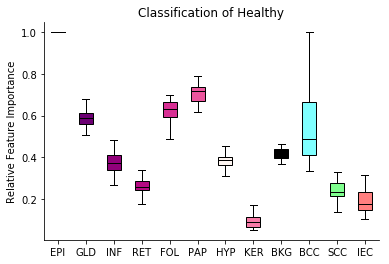

In [66]:
bplot = plt.boxplot(healthy_features,
                showfliers=False,
                medianprops=dict(color="black"),
                patch_artist=True
               )
plt.xticks(ticks=range(1, 13), labels=[color_dict[_][0] for _ in range(12)])
plt.ylabel("Relative Feature Importance")

for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)
    
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.title('Classification of Healthy')

plt.savefig("./relative_feature_importance_Healthy.png", dpi=300)
plt.show()

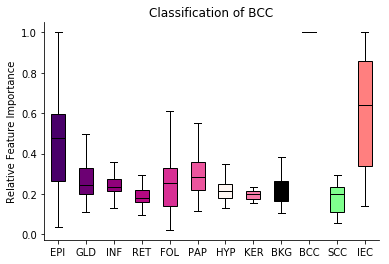

In [70]:
bplot = plt.boxplot(bcc_features,
                showfliers=False,
                medianprops=dict(color="black"),
                patch_artist=True
               )
plt.xticks(ticks=range(1, 13), labels=[color_dict[_][0] for _ in range(12)])
plt.ylabel("Relative Feature Importance")

for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)
    
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.title('Classification of BCC')

plt.savefig("./relative_feature_importance_BCC.png", dpi=300)
plt.show()

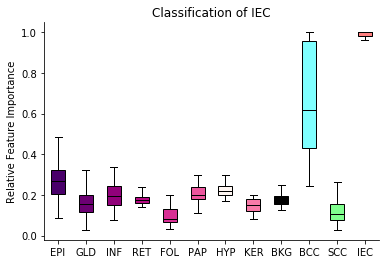

In [72]:
bplot = plt.boxplot(iec_features,
                showfliers=False,
                medianprops=dict(color="black"),
                patch_artist=True
               )
plt.xticks(ticks=range(1, 13), labels=[color_dict[_][0] for _ in range(12)])
plt.ylabel("Relative Feature Importance")

for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)
    
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.title('Classification of IEC')

plt.savefig("./relative_feature_importance_IEC.png", dpi=300)
plt.show()

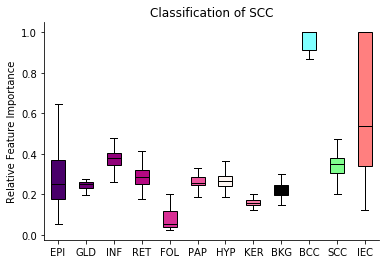

In [74]:
bplot = plt.boxplot(scc_features,
                showfliers=False,
                medianprops=dict(color="black"),
                patch_artist=True
               )
plt.xticks(ticks=range(1, 13), labels=[color_dict[_][0] for _ in range(12)])
plt.ylabel("Relative Feature Importance")

for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)
    
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.title('Classification of SCC')

plt.savefig("./relative_feature_importance_SCC.png", dpi=300)
plt.show()

In [81]:
combined_features = np.vstack([healthy_features, bcc_features, iec_features, scc_features])

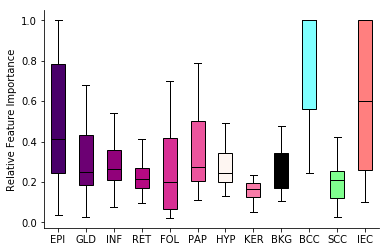

In [82]:
bplot = plt.boxplot(combined_features,
                showfliers=False,
                medianprops=dict(color="black"),
                patch_artist=True
               )
plt.xticks(ticks=range(1, 13), labels=[color_dict[_][0] for _ in range(12)])
plt.ylabel("Relative Feature Importance")

for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)
    
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.savefig("./relative_feature_importance_ALL.png", dpi=300)
plt.show()

In [96]:
random_combined_features = np.vstack([healthy_features, bcc_features, iec_features, scc_features])

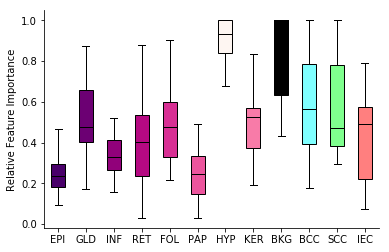

In [103]:
bplot = plt.boxplot(random_combined_features,
                showfliers=False,
                medianprops=dict(color="black"),
                patch_artist=True
               )
plt.xticks(ticks=range(1, 13), labels=[color_dict[_][0] for _ in range(12)])
plt.ylabel("Relative Feature Importance")

for patch, color in zip(bplot["boxes"], colors):
    patch.set_facecolor(color)
    
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.savefig("./relative_feature_importance_ALL_RANDOM.png", dpi=300)
plt.show()

# Confusion Matrix

In [169]:
cm = np.array([[16.,  0.,  0.,  0.],
       [ 1., 14.,  1.,  0.],
       [ 0.,  1.,  6.,  0.],
       [ 0.,  0.,  0.,  8.]])

In [170]:
cm = cm / np.sum(cm, axis=1)

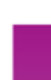

In [171]:
#from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [172]:
dark_purple = (162/255., 30/255., 140/255.) #rgb(64%, 12%, 55%)
grey = (0.94, 0.94, 0.94)

norm=plt.Normalize(0,1)
cmap = LinearSegmentedColormap.from_list("", [grey, dark_purple])

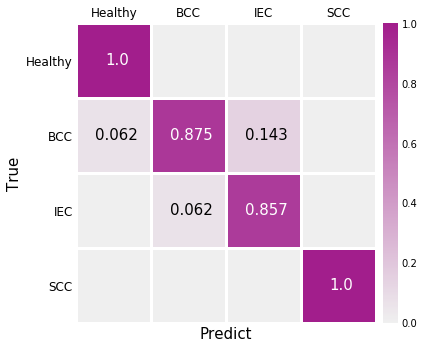

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cs = ax.matshow(cm, cmap=cmap)
ax.set_xlabel("Predict", fontsize=15)
ax.set_ylabel("True", fontsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.set_xticklabels(["_", "Healthy", "BCC", "IEC", "SCC"])
ax.set_yticklabels(["_", "Healthy", "BCC", "IEC", "SCC"])

ax.tick_params(length=0, which="both", labelsize=12)

ax.set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
ax.set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
ax.grid(which='minor', color="white", lw=3)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = plt.colorbar(cs, cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(length=0)

for r in range(4):
    for c in range(4):
        num = np.round(cm[r, c], 3)
        
        if num == 0:
            continue
            
        if r == c:
            if num == 1:
                ax.text(c-0.12, r+0.05, str(num), color="white", fontsize=15)
            else:
                ax.text(c-0.25, r+0.05, str(num), color="white", fontsize=15)
        
        else:
            ax.text(c-0.25, r+0.05, str(num), color="black", fontsize=15)
plt.tight_layout()
plt.savefig("./confusion_matrix_TEST.png", dpi=300)         
plt.show()

In [144]:
# binary

In [153]:
np.sum(cm[1:, 1:])

30.0

In [154]:
cm

array([[16.,  0.,  0.,  0.],
       [ 1., 14.,  1.,  0.],
       [ 0.,  1.,  6.,  0.],
       [ 0.,  0.,  0.,  8.]])

In [155]:
binary = np.array([[16, 0],
                   [1, 30]])

In [156]:
np.sum(np.diag(binary)) / np.sum(cm)

0.9787234042553191

In [165]:
# RF

cm = np.array([[13.,  2.,  1.,  0.],
                 [ 1., 14.,  1.,  0.],
                 [ 0.,  1.,  6.,  0.],
                 [ 0.,  0.,  0.,  8.]])


binary = np.array([[16, 3],
                   [1, np.sum(cm[1:, 1:])]])

np.sum(np.diag(binary)) / np.sum(cm)



0.9787234042553191

In [167]:
# KNN
cm = np.array([  [11.,  1.,  4.,  0.],
                 [ 0., 14.,  2.,  0.],
                 [ 2.,  0.,  5.,  0.],
                 [ 0.,  0.,  0.,  8.]])


binary = np.array([[11, 5],
                   [2, np.sum(cm[1:, 1:])]])

np.sum(np.diag(binary)) / np.sum(cm)


0.851063829787234

In [168]:
# SLP

cm = np.array([[13.,  3.,  0.,  0.],
               [ 2., 13.,  1.,  0.],
               [ 0.,  1.,  6.,  0.],
               [ 0.,  0.,  0.,  8.]])

binary = np.array([[13, 3],
                   [2, np.sum(cm[1:, 1:])]])

np.sum(np.diag(binary)) / np.sum(cm)


0.8936170212765957

## External Data

In [174]:
cm = np.array([ [40.,  0.,  0.,  0.],
                [ 2., 22.,  3.,  0.],
                [ 1.,  1., 21.,  1.],
                [ 0.,  0.,  6., 19.]])

In [175]:
cm = cm / np.sum(cm, axis=1)

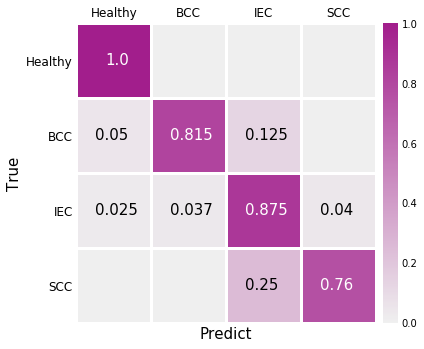

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cs = ax.matshow(cm, cmap=cmap)
ax.set_xlabel("Predict", fontsize=15)
ax.set_ylabel("True", fontsize=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.set_xticklabels(["_", "Healthy", "BCC", "IEC", "SCC"])
ax.set_yticklabels(["_", "Healthy", "BCC", "IEC", "SCC"])

ax.tick_params(length=0, which="both", labelsize=12)

ax.set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
ax.set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
ax.grid(which='minor', color="white", lw=3)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = plt.colorbar(cs, cax=cax)
cb.outline.set_visible(False)
cb.ax.tick_params(length=0)

for r in range(4):
    for c in range(4):
        num = np.round(cm[r, c], 3)
        
        if num == 0:
            continue
            
        if r == c:
            if num == 1:
                ax.text(c-0.12, r+0.05, str(num), color="white", fontsize=15)
            else:
                ax.text(c-0.25, r+0.05, str(num), color="white", fontsize=15)
        
        else:
            ax.text(c-0.25, r+0.05, str(num), color="black", fontsize=15)
plt.tight_layout()
plt.savefig("./confusion_matrix_EXT.png", dpi=300)         
plt.show()

In [158]:
np.sum(cm[1:, 1:])

73.0

In [3]:
cm = np.array([[40.,  0.,  0.,  0.],
       [ 2., 22.,  3.,  0.],
       [ 1.,  1., 21.,  1.],
       [ 0.,  0.,  6., 19.]])

In [1]:
import numpy as np

In [2]:
binary = np.array([[40, 0],
                   [3, 73]])

np.sum(np.diag(binary)) / np.sum(binary)

0.9741379310344828

In [4]:
np.sum(np.diag(cm)) / np.sum(cm)

0.8793103448275862

In [5]:
np.sum(cm)

116.0